In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
from torch import nn 
from torch.nn import functional as F 
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import BertTokenizer

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [4]:
data = pd.read_csv("/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_train.csv")

In [5]:
data = data[["sentence1", "sentence2", "gold_label"]]

In [6]:
data.isna().sum()

sentence1     0
sentence2     6
gold_label    0
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data = data[data["gold_label"] != "-"]

In [9]:
data

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment
...,...,...,...
550147,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',contradiction
550148,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",neutral
550149,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,neutral
550150,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,contradiction


In [10]:
strtolbl = {
    "neutral" : 0,
    "contradiction" : 1,
    "entailment" : 2
}
lbltostr = {
    0 : "neutral",
    1 : "contradiction",
    2 : "entailment"
}

In [11]:
data["gold_label"] = data["gold_label"].apply(lambda x : strtolbl[x])

## Maximum unique value for embeding of a token is 30,522 

In [12]:
class NLI_ds(Dataset):
    def __init__(self, data, max_len=512):
        super().__init__()
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_len
        
    def __len__(self):
        return data.shape[0]

    def __getitem__(self, idx):
        prm = data.iloc[idx]["sentence1"]
        hyp = data.iloc[idx]["sentence2"]
        conct = '[CLS]' + prm + '[SEP]' + hyp + '[SEP]'
        conct = self.tokenizer.encode(conct, add_special_tokens=False)
        conct = torch.tensor([conct + [self.tokenizer.pad_token_id] * (self.max_length - len(conct))]).squeeze(0)
        label = torch.tensor(data.iloc[idx]["gold_label"])
        return conct, label

In [13]:
train_size = 0.8
validation_size = 0.2

max_len = 512
max_tk_val = 30522
num_classes = 3
num_enc_blocks = 2
num_heads = 4
embed_dim = 256
head_dim = 64
num_experts = 3
hid_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 7
lr = 5e-5
batch_size = 256

In [14]:
dataset = NLI_ds(data, max_len)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
dataset[0][0].shape

torch.Size([512])

In [16]:
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_dataloader, validation_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

## Training function 

In [17]:
def train_model(model, device, optimizer, loss_module, train_data, num_epochs):
    train_losses = []
    
    pbar = tqdm(range(num_epochs))
    for ep in pbar:
        model.eval()
        epoch_loss = 0
        for text, lbl in tqdm(train_data):
            text = text.to(device)
            lbl = lbl.to(device)
            
            lbl_hat = model(text)
            loss = loss_module(lbl_hat, lbl)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss = epoch_loss/len(train_data)
        train_losses.append(epoch_loss)
        pbar.set_description(f"Epoch [{ep}] => Train Loss : [{epoch_loss}]")
    
    return model, train_losses
        

## Evaludation function

In [18]:
@torch.no_grad()
def eval_model(model, device, loss_module, data):
    model.eval()
    validation_loss = 0
    predictions = []
    true_labels = []
    for text, lbl in data:
        text = text.to(device)
        lbl = lbl.to(device)

        lbl_hat = model(text)
        loss = loss_module(lbl_hat, lbl)
        validation_loss += loss.item()

        # Convert predicted probabilities to labels
        predicted_labels = lbl_hat.argmax(dim=1)
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(lbl.cpu().numpy())

    validation_loss = validation_loss / len(data)
    return validation_loss, np.array(predictions), np.array(true_labels)

## Model definition

In [19]:
def attention_calculation(querys, keys, values, masked=False):
    D = querys.shape[-1]
    T = querys.shape[-2]
                              # query <B,L,D> ,  key <B,J,D>
    similarity = torch.einsum("bld, bjd -> blj", querys, keys)*(D**-0.5)
    
    if masked:
        masked = torch.tril(torch.ones((T,T)))
        similarity = similarity.masked_fill(masked == 0, float('-inf'))

    attention = F.softmax(similarity, dim=-1)
    weighted_values = torch.einsum("blj, bjd -> bld", attention, values)
    return weighted_values

class Head(nn.Module):
    def __init__(self, embed_dim, head_dim) :
        super().__init__()
        self.key_embeding = nn.Linear(embed_dim, head_dim)
        self.query_embeding = nn.Linear(embed_dim, head_dim)
        self.value_embeding = nn.Linear(embed_dim, head_dim)
    
    def forward(self, x): # x <b, l, D>
        keys = self.key_embeding(x)
        querys = self.query_embeding(x)
        values = self.value_embeding(x)
        return attention_calculation(querys, keys, values)
    
class Multihead(nn.Module):
    def __init__(self, num_heads, embed_dim, head_dim) :
        super().__init__()
        self.heads = nn.ModuleList([Head(embed_dim, head_dim) for _ in range(num_heads)])
        self.embed = nn.Linear(num_heads*head_dim, embed_dim)

    def forward(self, x):
        return self.embed(torch.cat([hed(x) for hed in self.heads], dim=-1))
    
class Expert(nn.Module):
    def __init__(self, embed_dim, hid_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, embed_dim)
        )
    
    def forward(self,x): # x <B,L,D>
        return self.ff(x)

class MOE(nn.Module):
    def __init__(self, num_experts, embed_dim, hid_dim) :
        super().__init__()
        self.experts = nn.ModuleList([Expert(embed_dim, hid_dim) for _ in range(num_experts)])
        self.rooter = nn.Linear(embed_dim, num_experts)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        rooter = self.softmax(self.rooter(x)) #in <B,L,D> -> out <B,L,Num_exprts>
        exprts = torch.stack([exprt(x) for exprt in self.experts],dim=1) #in <B,L,D> -> out <B, Num_exprts, L, D>
        return torch.einsum("ble,beld -> bld", rooter, exprts)

class Encoder_block(nn.Module):
    def __init__(self, num_heads, embed_dim, head_dim, num_experts,hid_dim) :
        super().__init__()
        self.mhd = Multihead(num_heads, embed_dim, head_dim)
        self.lyrnorm_mh = nn.LayerNorm(embed_dim)
        self.lyrnorm_ff = nn.LayerNorm(embed_dim)
        self.moe = MOE(num_experts, embed_dim, hid_dim)
    
    def forward(self, x):
        mlth = self.mhd(self.lyrnorm_mh(x)) + x
        return self.moe(self.lyrnorm_ff(mlth)) + mlth

        
class DecisionMaker(nn.Module):
    def __init__(self, max_tk_val, max_len, num_enc_blocks, num_heads, embed_dim, head_dim, num_experts, hid_dim, num_classes, device = 'cpu') :
        super().__init__()
        self.encoder = nn.Sequential(*[Encoder_block(num_heads, embed_dim, head_dim, num_experts, hid_dim) for _ in range(num_enc_blocks)])
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.softmax = nn.Softmax(dim = -1)
        self.word_embedding = nn.Embedding(num_embeddings=max_tk_val, embedding_dim= embed_dim)
        self.positional_embedding = nn.Embedding(num_embeddings=max_len, embedding_dim= embed_dim)
        self.sentence_tokenize = nn.Embedding(2, embed_dim)
        self.max_len = max_len
        self.device = device
        self.to(device)

    def forward(self, text):
        text_embd = self.word_embedding(text)
        position_vectors = torch.arange(start= 0, end= self.max_len, device = self.device)
        position_vectors = self.positional_embedding(position_vectors)
        hdn = self.encoder(text_embd + position_vectors) # <B, L, D>  D = embed_dim
        return self.softmax(self.classifier(hdn[:,0]))

In [20]:
# initialize model
model = DecisionMaker(max_tk_val, max_len, num_enc_blocks, num_heads, embed_dim, head_dim, num_experts, hid_dim, num_classes, device)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_module = nn.CrossEntropyLoss()

In [22]:
# train the model
model, train_losses = train_model(model, device, optimizer, loss_module, train_dataloader, num_epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

  0%|          | 0/1717 [00:00<?, ?it/s]

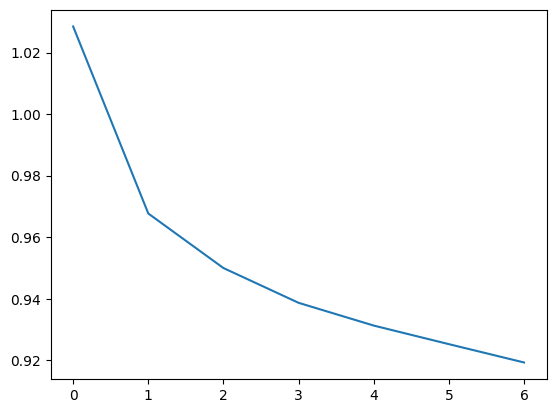

In [23]:
plt.plot(train_losses)

In [24]:
val_loss, predictions, true_labels = eval_model(model, device, loss_module, validation_dataloader)

Accuracy: 0.6005806756953546
AUC: 0.7003569370801249
F1 Score: 0.5995687113675093
Confusion Matrix:


<Axes: >

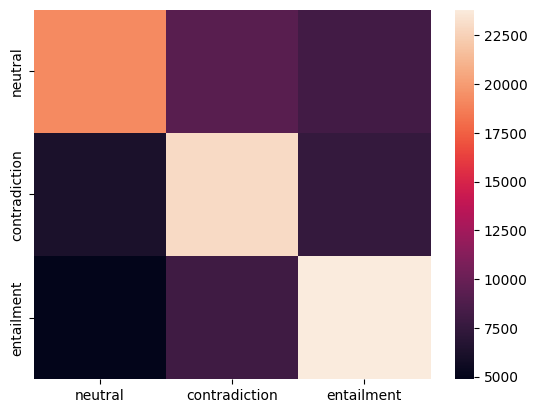

In [25]:
# Convert the predicted labels to predicted probabilities using one-hot encoding 
predicted_probs = np.zeros((len(predictions), num_classes))
for i in range(len(predictions)):
    predicted_probs[i, predictions[i]] = 1
    
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
auc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr')
f1 = f1_score(true_labels, predictions, average='weighted')
cm = confusion_matrix(true_labels, predictions)


print("Accuracy:", accuracy)
print("AUC:", auc)
print("F1 Score:", f1)
print("Confusion Matrix:")
sns.heatmap(cm, xticklabels=[lbltostr[k] for k in lbltostr], yticklabels=[lbltostr[k] for k in lbltostr])

In [26]:
@torch.no_grad()
def calculate_num_correct_labels(model, validation_dataloader):
    num_correct = 0
    total_labels = 0
    model.eval()
    for text, lbl in validation_dataloader:
        text = text.to(device)
        lbl = lbl.to(device)
        logits = model(text)
        predicted_labels = logits.argmax(dim=-1)
        num_correct += (predicted_labels == lbl).sum().item()
        total_labels += lbl.size(0)
    model.train()
    return num_correct, total_labels

In [27]:
calculate_num_correct_labels(model, validation_dataloader)

(65987, 109872)